In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set device for PyTorch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_weeks=4):
    model.eval()
    predictions = []
    last_window = features_scaled[-window_size:]
    last_price = float(stock_data['Close'].iloc[-1].iloc[0])
    last_features = enhanced_data.iloc[-1]
    
    # Start from today
    today = datetime.now()
    # Calculate days until next Friday (4 is Friday)
    days_until_friday = (4 - today.weekday()) % 7
    if days_until_friday == 0 and today.hour >= 16:  # If it's Friday after market close
        days_until_friday = 7
    
    next_friday = today + timedelta(days=days_until_friday)
    # Generate the next 4 Fridays
    prediction_dates = [next_friday + timedelta(weeks=i) for i in range(num_weeks)]
    
    with torch.no_grad():
        current_window = torch.FloatTensor(last_window).unsqueeze(0).to(device)
        current_price = last_price
        
        # Initialize volatility tracking
        rolling_volatility = enhanced_data['10d_vol'].iloc[-1]  # Use 10-day vol for shorter term
        rsi = enhanced_data['RSI'].iloc[-1]
        stoch_rsi_k = enhanced_data['STOCH_RSI_K'].iloc[-1]
        volume_trend = enhanced_data['Volume_Change'].iloc[-1]
        
        for i in range(len(prediction_dates)):
            # Predict base percentage change
            pct_change = model(current_window).item()
            
            # Add short-term volatility adjustments
            vol_factor = rolling_volatility * np.random.normal(0, 1)
            
            # RSI-based adjustment (more volatile when RSI is at extremes)
            rsi_factor = 0.0
            if rsi > 70 or rsi < 30:
                rsi_factor = (rsi - 50) / 50.0 * -0.01  # Mean reversion at extremes
            
            # StochRSI momentum adjustment
            momentum_factor = (stoch_rsi_k - 50) / 50.0 * 0.005
            
            # Volume impact
            volume_impact = np.sign(volume_trend) * min(abs(volume_trend), 0.01)
            
            # Combine all factors
            adjusted_pct_change = pct_change + vol_factor + rsi_factor + momentum_factor + volume_impact
            
            # Calculate predicted price
            predicted_price = current_price * (1 + adjusted_pct_change)
            predictions.append(predicted_price)
            
            # Update for next prediction
            current_price = predicted_price
            
            # Update indicators
            rolling_volatility = rolling_volatility * 0.8 + abs(adjusted_pct_change) * 0.2
            rsi = max(0, min(100, rsi + adjusted_pct_change * 20))
            stoch_rsi_k = max(0, min(100, stoch_rsi_k + adjusted_pct_change * 15))
            volume_trend = volume_trend * 0.7 + np.random.normal(0, 0.1)
            
            # Create new window by shifting
            new_window = current_window.clone()
            new_window[0, :-1, :] = new_window[0, 1:, :]
            
            # Update features with more realistic variations
            new_features = last_features.copy()
            new_features['Close'] = predicted_price
            new_features['Open'] = predicted_price * (1 + np.random.normal(0, 0.005))
            new_features['High'] = predicted_price * (1 + abs(np.random.normal(0, 0.01)))
            new_features['Low'] = predicted_price * (1 - abs(np.random.normal(0, 0.01)))
            new_features['Volume'] = new_features['Volume'] * (1 + volume_trend)
            
            # Update technical indicators
            new_features['10d_vol'] = rolling_volatility
            new_features['RSI'] = rsi
            new_features['STOCH_RSI_K'] = stoch_rsi_k
            new_features['Volume_Change'] = volume_trend
            
            # Scale the new features
            scaled_new_features = scaler.transform(new_features.values.reshape(1, -1))[0]
            new_window[0, -1, :] = torch.FloatTensor(scaled_new_features).to(device)
            current_window = new_window

    # Create DataFrame with more detailed predictions
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted Price': predictions,
        'Pct_Change': [(p/last_price - 1)*100 for p in predictions],
        'Volatility': [rolling_volatility * 100] * len(predictions),
        'RSI': [rsi] * len(predictions),
        'StochRSI_K': [stoch_rsi_k] * len(predictions)
    })
    
    print("\nPredictions for upcoming Fridays:")
    print(prediction_df.to_string(float_format=lambda x: '{:.2f}'.format(x)))
    
    # Enhanced visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Price plot
    ax1.plot(stock_data.index[-20:], stock_data['Close'][-20:], label='Historical')
    ax1.plot(prediction_dates, predictions, label='Predicted', linestyle='--')
    ax1.set_title(f'{ticker} Stock Price Prediction (Weekly Friday Closes)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Technical indicators plot
    ax2.plot(prediction_dates, prediction_df['RSI'], label='RSI', color='blue')
    ax2.plot(prediction_dates, prediction_df['StochRSI_K'], label='StochRSI_K', color='green')
    ax2.plot(prediction_dates, prediction_df['Volatility'], label='Volatility %', color='red')
    ax2.set_title('Technical Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return prediction_df

Using device: mps


[*********************100%***********************]  1 of 1 completed

model_dir /Users/makeen/dev/StockModel/notebooks/saved_models/stock_options_high_interest_model
Model loaded: stock_options_high_interest_model

Generating predictions for LGTY
Columns after processing: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change  Volatility   RSI  StochRSI_K
0 2025-04-11 17:49:40.633604            14.35        0.39        0.39 73.89        0.32
1 2025-04-18 17:49:40.633604            14.40        0.79        0.39 73.89        0.32
2 2025-04-25 17:49:40.633604            14.48        1.36        0.39 73.89        0.32
3 2025-05-02 17:49:40.633604            14.60        2.15        0.39 73.89        0.32


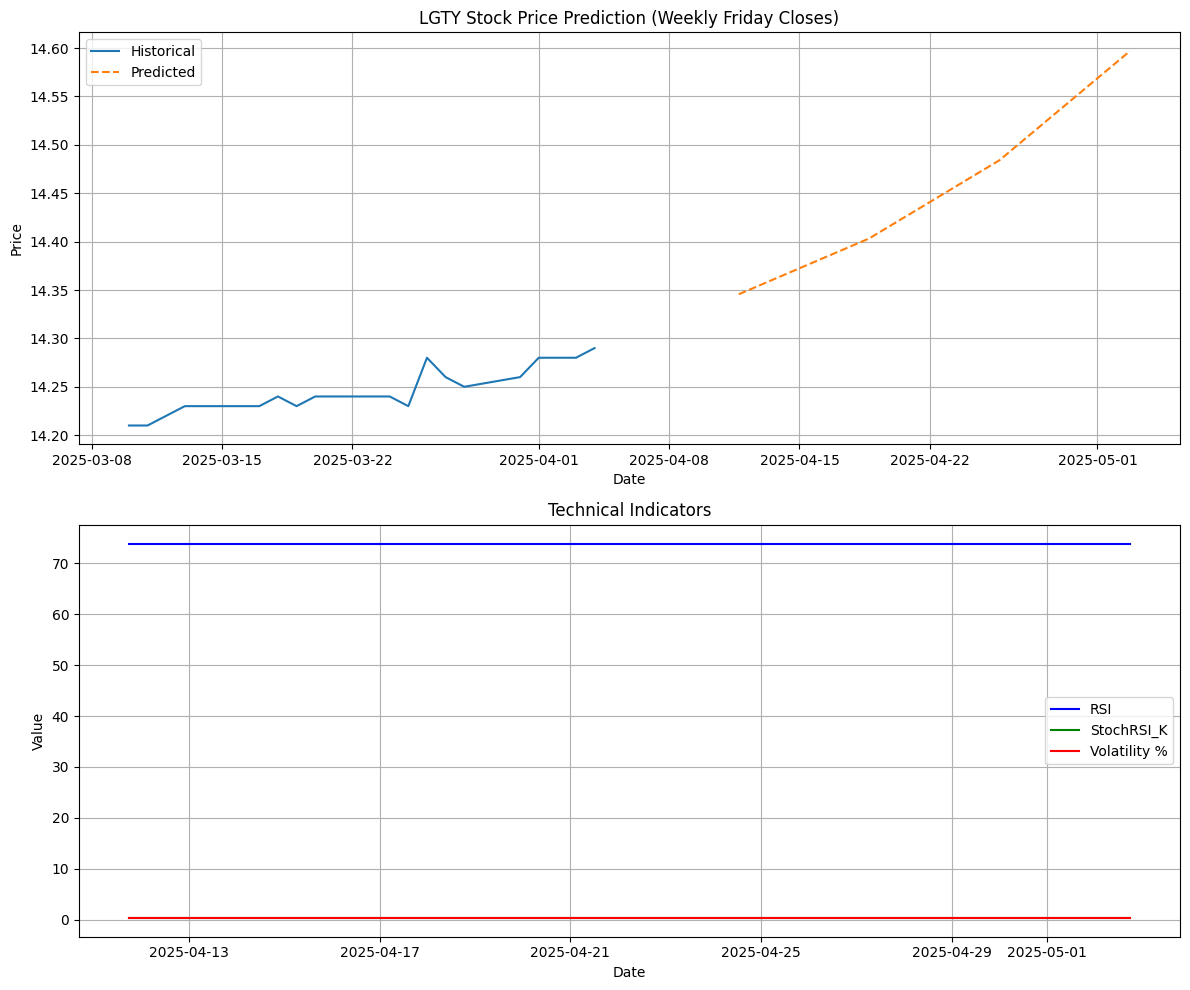

In [8]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.models.train import train
from utils.models.save import save
from utils.models.load import load
from utils.stocks.get_high_interest import get_high_interest_tickers
from utils.stocks.download_stock_data import download_stock_data
from utils.stocks.add_short_term_stock_features import add_short_term_stock_features
from utils.training.short_term_growth import short_term_growth
from utils.stocks.get_short_term_stock_features import get_short_term_stock_features

model_name = "stock_options_high_interest_model"

# Try to load existing model first
model, scaler, last_data = load(model_name)

if model is None:
    print(f"Training new model.")
    # these tickers are used for training
    # they create the model baseline that we want to beat or match
    high_options_interest_stocks = get_high_interest_tickers()

    model, scaler = short_term_growth(high_options_interest_stocks, model_name)
    # Verify we have a NEW model and scaler before proceeding
    if model is None or scaler is None:
        print("No valid model and scaler available. Cannot proceed with predictions.")
        exit()

# Verify we have a PRE_LOADED model and scaler before proceeding
if model is None or scaler is None:
    print("No valid model and scaler available. Cannot proceed with predictions.")
    exit()

# for analysis, these tickers use the model for prediction!
# this is where you set your stock symbols you want to predict on
tickers = ["LGTY"]

# Run the model for each ticker
for ticker in tickers:
    print(f"\nGenerating predictions for {ticker}")
    stock_data = download_stock_data(ticker, 
                                    datetime.now() - timedelta(days=30),
                                    datetime.now())
    enhanced_data = add_short_term_stock_features(stock_data, ticker)
    
    # Define available features (make sure this matches your training features)
    short_term_growth_features = get_short_term_stock_features()
        
    features = enhanced_data[short_term_growth_features].values
    if features.size == 0:
        raise ValueError("No valid features extracted")
    features_scaled = scaler.transform(features)
    predictions = predict(model, features_scaled, 20, ticker, scaler, stock_data, enhanced_data, num_weeks=4)